In this section, we investigate the relationship between the target article sentiment and how it influences the path structure.
1. How does the sentiment score of a target topic affect the general <b><u>structure</u></b> of the path chosen by players? 
2. Is there a relationship between the extremity of a target article's sentiment (highly positive/negative) and the <b><u>length</u></b> of the path taken to reach it? We can decompose this in two causal questions. When players choose <b><u>shorter paths</u></b>, are these paths characterized by articles with, for example, more extreme sentiment scores? Conversely, do extreme-sentiment paths mean shorter paths?

### 1. Sentiment and Path Structure

In [1]:
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import interp1d

import statsmodels.formula.api as smf

In [2]:
with open("df_paths1.pickle", "rb") as f:
    df = pickle.load(f)

Let's add some utility columns in the dataframe.

In [3]:
df["Scores_mean"] = df["Scores"].apply(lambda x: sum(x)/len(x))
df["Path_length"] = df["Scores"].apply(lambda x: len(x))

In [4]:
display(df)

,Scores,Rounded,Target score,Scores_mean,Path_length
0,"[-0.14721301536458237, -0.028293290087380706, ...","[0, 0, 0, 0, 0, 0, 0, -1, -1]",NaN,-0.204399,9
1,"[-0.14721301536458237, -0.048477304979667915, ...","[0, 0, 0, -1, -1]",NaN,-0.386558,5
2,"[-0.14721301536458237, -0.052448976123087784, ...","[0, 0, -1, 0, -1, 0, -1, -1]",NaN,-0.457848,8
3,"[-0.14721301536458237, 0.037461097698424525, -...","[0, 0, 0, 0]",NaN,-0.020967,4
4,"[-0.14721301536458237, -0.06396592637112342, 0...","[0, 0, 0, -1, 0, 0, 0]",NaN,-0.177478,7
...,...,...,...,...,...
76159,"[0.011778271523728776, -0.8782995301658347, -0...","[0, -1, 0, -1, -1, 0]",-0.826112,-0.409196,6
76160,[-0.18600953180292576],[0],0.282791,-0.186010,1
76161,"[0.7375556848610064, 0.0948245586412504, -0.05...","[1, 0, 0]",0.072405,0.258806,3
76162,"[-0.011092642140131198, 0.11030565085346924, -...","[0, 0, -1, -1]",-0.131333,-0.382254,4


Note: when ```Target score``` is NaN, it means that the target score is reached therefore the score can be found in the last element of the corresponding ```Scores``` list. When it is not reached, the score is specified in this ```Target score``` column.

For this first question, we want to visualize the paths. For this, we use a heatmap and interpolate the sentiments from adjacent paths to get a better sense of the structure of paths.

In [5]:
max_path_length = 20
path_resolution = 20  # resolution between 2 articles; e.g. with 20: there are 20 points between source and 1st article clicked
score_resolution = 80 # 20 -> [-1, -0.9, ..., 0.9, 1]
score_step = (1-(-1))/score_resolution

def path_heatmap(df, title="Scores Heatmap", remove_target=False):
    """
    Heatmap method for visualizing paths of a pandas DataFrame. 
    Parameters for the function are defined above in the cell.
    Note that max_path_length can also be set to the maximum length of paths 
        in the DataFrame using df["Scores"].apply(len).max(), but in this case
        the max length is very big (~400) so by default the articles after max_path_length
        are aggregated in the farthest point of the heatmap (on the right of the plot).
    
    Input params:
        - df: (pandas.core.frame.DataFrame) dataframe with a 
            column Scores that contains lists of sentiment scores
        - title: (str) title for the heatmap
        - remove_target: (bool) remove the last element of each list of sentiments 
            for better visibility in the heatmap
        
    Output:
        - axis (matplotlib.image.AxesImage) of the plot of a heatmap of the sentiments, 
            interpolated between articles so that the fluctuations of sentiments are visualized
    """
    
    path_scores_heatmap = np.zeros((score_resolution, path_resolution*max_path_length))

    for i in df.index:
        path = df.loc[i]["Scores"][:-1] if remove_target else df.loc[i]["Scores"]
        
        # fix bug: some paths are Series, not list
        if type(path) != list:
            path = list(path)[0]
        x = np.arange(len(path))
        # print(x, type(x), len(path), path, type(path))
        f = interp1d(x,path)
        path_space = np.linspace(0,len(path)-1, path_resolution*len(path))
        f_path_space = f(path_space)
        for path_ind,score in enumerate(f_path_space):
            y_ind = round(score/score_step) + score_resolution//2
            path_scores_heatmap[y_ind, min(path_ind,path_resolution*max_path_length-1)] += 1

    # Plot the heatmap
    ax = plt.imshow(np.log(np.flipud(path_scores_heatmap)+1), aspect='auto', cmap='viridis', interpolation='nearest', extent=[0,12,-1,1])
    plt.colorbar()
    plt.xlabel('Path Index')
    plt.ylabel('Sentiment score $\in[-1,1]$')
    plt.title(title)
    plt.show()
    return ax

Let's visualize a random subset of the paths.

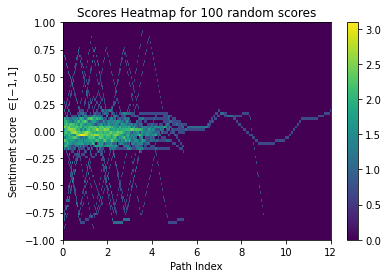

In [6]:
size=100
rand_ind = np.random.choice(df.index, size=size)
path_heatmap(df[df["Path_length"] > 2].filter(items = rand_ind, axis=0), 
             title=f"Scores Heatmap for {size} random scores")
plt.show()

It is clear that most of the paths are centered in the neutral sentiment zone. This is due to the sentiment evaluation method that we chose (see above) which scores a large majority of the articles as neutral. Another thing we note is that most of the "high-sentiment" articles are negative. Indeed, again in the distribution of the article scores above, we saw that there were more negative articles than positive ones.

Now, let's dive into a causal analysis on whether or not the target sentiment affects the path structure. For now, we keep the "structure" feature purely a descriptive, non-formal one. 

But first, we notice that many of the paths have very short length, and we wonder whether these are of interest for our analysis. There are about 10,000 paths with length 1 or 2:

In [7]:
len(df[(df["Path_length"] <= 2)])

10495

Out of these, only about 800 do actually reach their target (see cell below). Note that the paths that reach their target are the ones for which the column Target score is a NaN value as the target score is already present in the Scores column (since it is reached).

In [8]:
len(df[(df["Path_length"] <= 2) & (df["Target score"].apply(lambda x: np.isnan(x)))])

831

We decide that short paths that do not reach their target are "rage-quits": they do not provide useful information for our analysis (they are noise). Similarly, short paths that reach their target are also noise: they are too easy! In both cases, neither does provide useful information, so we discard these in our following analyses. Now, let's focus on splitting the data according to the target's sentiment.

In [9]:
df = df[df["Path_length"] > 2]

Let's gather the target articles' scores in a new column. Note that we differentiate the case where the target article was found or not. We then split the dataframe in 3 frames depending on the target score. 

In [10]:
df["target_score_raw"] = df.apply(lambda x: x['Scores'][-1] if np.isnan(x['Target score']) else x['Target score'], axis=1)
df_positive = df[df["target_score_raw"] >= 0.5]
df_neutral = df[(df["target_score_raw"] > -0.5) & (df["target_score_raw"] < 0.5)]
df_negative = df[df["target_score_raw"] <= -0.5]

Note that the scores where we split the data seem arbitrary, but in fact the scores are very well split (we refer here again to the histogram of the articles' sentiment scores).

In [11]:
df_positive.describe()

,Target score,Scores_mean,Path_length,target_score_raw
count,438.000000,2030.000000,2030.000000,2030.000000
mean,0.761764,0.098503,6.032020,0.758437
std,0.055430,0.141188,3.248302,0.050272
min,0.700043,-0.865857,3.000000,0.700043
25%,0.717978,0.010624,4.000000,0.716237
50%,0.747766,0.112524,5.000000,0.750177
75%,0.777580,0.182197,7.000000,0.782183
max,0.939431,0.626832,67.000000,0.943384


In [12]:
df_negative.describe()

,Target score,Scores_mean,Path_length,target_score_raw
count,1316.000000,5960.000000,5960.000000,5960.000000
mean,-0.821085,-0.242910,5.866443,-0.816736
std,0.092857,0.170273,3.084960,0.087023
min,-1.000000,-0.942485,3.000000,-1.000000
25%,-0.879634,-0.353202,4.000000,-0.865036
50%,-0.790648,-0.225142,5.000000,-0.804227
75%,-0.740544,-0.136337,7.000000,-0.742560
max,-0.700808,0.440404,102.000000,-0.700045


In [13]:
df_neutral.describe()

,Target score,Scores_mean,Path_length,target_score_raw
count,13428.000000,57679.000000,57679.000000,57679.000000
mean,-0.026903,-0.045076,6.010506,-0.029277
std,0.109761,0.111394,3.536139,0.103377
min,-0.385264,-0.878111,3.000000,-0.385264
25%,-0.122357,-0.083277,4.000000,-0.109475
50%,-0.038557,-0.033339,5.000000,-0.040235
75%,0.057017,0.010639,7.000000,0.042937
max,0.299472,0.627172,405.000000,0.299472


[Comment on ...]

Let us now visualize the paths using the heatmap tool. Note that the heatmap does not show the target sentiment, as this would add noise on the image (it would show more negativity when in reality it just represents the last click to the target).

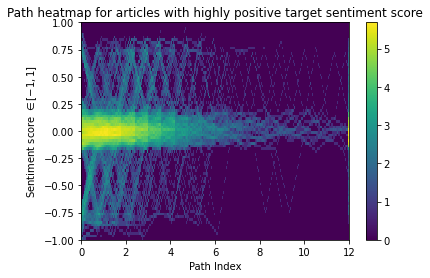

In [14]:
path_heatmap(df_positive, 
             title="Path heatmap for articles with highly positive target sentiment score", 
             remove_target=True)
plt.show()

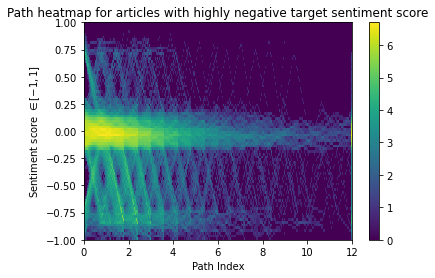

In [15]:
path_heatmap(df_negative, 
             title="Path heatmap for articles with highly negative target sentiment score", 
             remove_target=True)
plt.show()

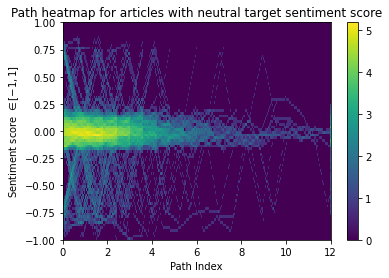

In [16]:
path_heatmap(df_neutral.filter(items=np.random.choice(df_neutral.index, size=1000), axis=0), 
             title="Path heatmap for articles with neutral target sentiment score", 
             remove_target=True)
plt.show()

In the negative targets heatmap, it seems that there are much more negative articles along the path. However, surprisingly, in the positive targets heatmap, the paths are pretty balanced. One interesting thing to note is that the first few articles in the paths seems more negative, while in the later stages they seem more positive. Both these observations confirm the somewhat trivial statement: paths with positive targets tend to be more positive in the end of the paths, while paths with negative targets tend to get more negative in the end of the paths. Indeed, it seems logical that similar articles have similar sentiments (cf. subquestion 6), and that adjacent articles in the paths are of similar topics, therefore that sentiment scores before targets are similar to that of targets.

### 2. Target sentiment ~ path length ?

Let's try making a predictive model to determine the strength of the relationship between target sentiment and path length. Can a model predict the path length given the target sentiment?

In [17]:
df["is_target_positive"] = df["target_score_raw"] > 0.5
df["is_target_negative"] = df["target_score_raw"] < -0.5

In [18]:
df["is_target_positive"].sum(), df["is_target_negative"].sum()

(2030, 5960)

There are 2030 games with positive target, and 5960 games with negative targets.

In [19]:
mod = smf.ols(formula='Path_length ~ C(is_target_positive) + C(is_target_negative)', data=df)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Path_length   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     4.704
Date:                Fri, 22 Dec 2023   Prob (F-statistic):            0.00906
Time:                        19:18:40   Log-Likelihood:            -1.7524e+05
No. Observations:               65669   AIC:                         3.505e+05
Df Residuals:                   65666   BIC:                         3.505e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         6.0105      0.015    413.736      0.000       5.982       6.039
C(is_target_positive)[T.True]     0.0215      0.079      0.273      0.785      -0.133       0.176
C(is_target_negative)[T.True]    -0.1441      0.047     -3.035      0.002      -0.237      -0.051
==============================================================================
Omnibus:                   166985.510   Durbin-Watson:                   1.845
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      19940403342.826
Skew:                          27.681   Prob(JB):                         0.00
Kurtosis:                    2701.989   Cond. No.                         5.82
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The negativity of target seems to have some link towards predicting the path length. There is some negative correlation, and it is significant at the $0.05$ significance level because the p-value for the coefficient is $0.002$, indicating that we cannot reject the null hypothesis that there is no correlation between negativity of target sentiment and path length. Let us verify that the fact that a target is reached or not is a confounder variable in that case. 

In [20]:
df["is_target_negative_and_reached"] = np.where((df["target_score_raw"] < -0.5) & np.isnan(df["Target score"]), 1, 0)
df["is_target_negative_and_not_reached"] = np.where((df["target_score_raw"] < -0.5) & (~ np.isnan(df["Target score"])), 1, 0)
df["is_target_positive_and_reached"] = np.where((df["target_score_raw"] > 0.5) & np.isnan(df["Target score"]), 1, 0)
df["is_target_positive_and_not_reached"] = np.where((df["target_score_raw"] > 0.5) & (~ np.isnan(df["Target score"])), 1, 0)
df.head()

,Scores,Rounded,Target score,Scores_mean,Path_length,target_score_raw,is_target_positive,is_target_negative,is_target_negative_and_reached,is_target_negative_and_not_reached,is_target_positive_and_reached,is_target_positive_and_not_reached
0,"[-0.14721301536458237, -0.028293290087380706, ...","[0, 0, 0, 0, 0, 0, 0, -1, -1]",NaN,-0.204399,9,-0.787055,False,True,1,0,0,0
1,"[-0.14721301536458237, -0.048477304979667915, ...","[0, 0, 0, -1, -1]",NaN,-0.386558,5,-0.787055,False,True,1,0,0,0
2,"[-0.14721301536458237, -0.052448976123087784, ...","[0, 0, -1, 0, -1, 0, -1, -1]",NaN,-0.457848,8,-0.787055,False,True,1,0,0,0
3,"[-0.14721301536458237, 0.037461097698424525, -...","[0, 0, 0, 0]",NaN,-0.020967,4,0.080644,False,False,0,0,0,0
4,"[-0.14721301536458237, -0.06396592637112342, 0...","[0, 0, 0, -1, 0, 0, 0]",NaN,-0.177478,7,-0.051500,False,False,0,0,0,0


In [21]:
mod = smf.ols(formula='Path_length ~ C(is_target_negative_and_reached) + \
                                     C(is_target_negative_and_not_reached) + \
                                     C(is_target_positive_and_reached) + \
                                     C(is_target_positive_and_not_reached)', data=df)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Path_length   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     4.561
Date:                Fri, 22 Dec 2023   Prob (F-statistic):            0.00111
Time:                        19:18:41   Log-Likelihood:            -1.7523e+05
No. Observations:               65669   AIC:                         3.505e+05
Df Residuals:                   65664   BIC:                         3.505e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================================================
                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
Intercept                                      6.0105      0.015    413.758      0.000       5.982       6.039
C(is_target_negative_and_reached)[T.1]        -0.1018      0.053     -1.913      0.056      -0.206       0.002
C(is_target_negative_and_not_reached)[T.1]    -0.2932      0.097     -3.014      0.003      -0.484      -0.103
C(is_target_positive_and_reached)[T.1]         0.1189      0.089      1.341      0.180      -0.055       0.293
C(is_target_positive_and_not_reached)[T.1]    -0.3324      0.167     -1.987      0.047      -0.660      -0.004
==============================================================================
Omnibus:                   167003.365   Durbin-Watson:                   1.845
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      19951452208.502
Skew:                          27.688   Prob(JB):                         0.00
Kurtosis:                    2702.736   Cond. No.                         12.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

At the $0.05$ significance level, the coefficient for the articles with reached targets is <b>not</b> significant, while the coefficient for the articles with <b>un</b>reached targets is significant. We conclude that unreached targets lower the average game length... the fact that a game is finished was indeed a confounder. This conclusion is clearly trivial: when players give up, it shortens the path length. 

It would have been interesting to observe that, for instance, negative targets are more likely to make the player give up than positive targets. However, it does not seem to be the case. What does that tell us about human psychology online? When exploring the web, have we become completely insensible machines, completely unmindful of the information we are reading? In a competitive context where both time and strategy are competing inside one's thinking process, it seems that from our analyses we cannot reach a unified conclusion about the effect of the target article's sentiment.